In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import random
import numpy as np
import torch
import tqdm
from job_shop_lib.dispatching.feature_observers import (
    FeatureObserverType,
)
from job_shop_lib.graphs import build_resource_task_graph
from job_shop_lib.reinforcement_learning import (
    SingleJobShopGraphEnv,
    ResourceTaskGraphObservation,
    get_optimal_actions,
)
from job_shop_lib.dispatching import OptimalOperationsObserver
from job_shop_lib import Schedule
from gnn_scheduler.utils import get_data_path
from gnn_scheduler.data import JobShopData

/home/pablo/VSCodeProjects/gnn_scheduler/.venv/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [3]:
DATA_PATH = get_data_path()
schedules_json = json.load(open(DATA_PATH / "small_random_instances_0.json"))

In [4]:
# from job_shop_lib.constraint_programming import ORToolsSolver
# from job_shop_lib.generation import GeneralInstanceGenerator
# import tqdm

# instance_generator = GeneralInstanceGenerator(
#     duration_range=(1, 10),
#     num_jobs=4,
#     num_machines=3,
#     iteration_limit=1000,
#     seed=42,
# )
# schedules_json = []
# for instance in tqdm.tqdm(instance_generator):
#     solver = ORToolsSolver()
#     schedule = solver.solve(instance)
#     schedules_json.append(schedule.to_dict())

In [5]:
len(schedules_json)

100000

In [6]:
features_observers_types = [
    FeatureObserverType.DURATION,
    FeatureObserverType.EARLIEST_START_TIME,
    FeatureObserverType.IS_SCHEDULED,
    FeatureObserverType.POSITION_IN_JOB,
    FeatureObserverType.REMAINING_OPERATIONS,
]

In [7]:
OPERATION_FEATURES_TO_NORMALIZE = [
    0,  # Duration
    1,  # EarliestStartTime
    4,  # PositionInJob
    5,  # Job duration
    6,  # Job earliest start time
    9,  # Job remaining operations
]
MACHINE_FEATURES_TO_NORMALIZE = [
    0,  # Duration
    1,  # EarliestStartTime
    4,  # RemainingOperations
]

features_to_normalize = {
    "operation": OPERATION_FEATURES_TO_NORMALIZE,
    "machine": MACHINE_FEATURES_TO_NORMALIZE,
}

In [8]:
def _normalize_features(
    node_features_dict: dict[str, np.ndarray],
    indices_to_normalize: dict[str, list[int]] | None = None,
):
    if indices_to_normalize is None:
        indices_to_normalize = {
            "operation": np.arange(8),
            "machine": np.arange(4),
        }
    for key, indices in indices_to_normalize.items():
        # Divide by the maximum value checking for division by zero
        max_values = np.max(node_features_dict[key], axis=0)
        max_values[max_values == 0] = 1
        node_features_dict[key][:, indices] /= max_values[indices]

    return node_features_dict

In [ ]:
def _map_available_operations_with_ids_to_original_ids(
    available_operations_with_ids, original_ids: dict[str, np.ndarray]
):
    new_ids = []
    for operation_id, machine_id, job_id in available_operations_with_ids:
        original_operation_id = original_ids["operation"][operation_id]
        original_machine_id = original_ids["machine"][machine_id]
        new_ids.append((original_operation_id, original_machine_id, job_id))
    return new_ids

In [ ]:
dataset = {}
for schedule_dict in tqdm.tqdm(schedules_json):
    observations = []
    action_probabilities_sequence = []
    schedule = Schedule.from_dict(**schedule_dict)
    graph = build_resource_task_graph(schedule.instance)
    env = SingleJobShopGraphEnv(
        graph,
        feature_observer_configs=features_observers_types,
        ready_operations_filter=None,
    )
    env = ResourceTaskGraphObservation(env)
    optimal_ops_observer = OptimalOperationsObserver(
        env.unwrapped.dispatcher, schedule
    )
    correct_schedule = False
    attempts = 0
    while not correct_schedule:
        obs, info = env.reset()
        done = False
        while not done:

            action_probs = get_optimal_actions(
                optimal_ops_observer,
                _map_available_operations_with_ids_to_original_ids(
                    info["available_operations_with_ids"],
                    obs["original_ids_dict"],
                ),
            )
            if len(action_probs) > 1:
                obs["node_features_dict"] = _normalize_features(
                    obs["node_features_dict"]
                )
                observations.append(obs)
                action_probabilities_sequence.append(action_probs)
            if max(action_probs.values()) != 1.0:
                correct_schedule = False
                break
            optimal_actions = [
                action
                for action, value in action_probs.items()
                if value == 1.0
            ]
            action_choice = random.choice(optimal_actions)
            _, machine_id, job_id = action_choice
            # machine_id = obs["original_ids_dict"]["machine"][machine_id]
            obs, reward, done, _, info = env.step((job_id, machine_id))
        makespan = env.unwrapped.dispatcher.schedule.makespan()
        correct_schedule = makespan == schedule.makespan()
        if not correct_schedule:
            attempts += 1
            name = schedule.instance.name
            print(f"Failed to generate correct schedule for {name}")
            print(f"Attempt {attempts}")
            if attempts >= 100:
                raise ValueError("Failed to generate correct schedule")
    dataset[schedule.instance.name] = (
        observations,
        action_probabilities_sequence,
    )

  0%|          | 350/100000 [00:12<59:01, 28.14it/s]  


KeyboardInterrupt: 

In [21]:
x = 10
list(dataset.values())[0][1][x]

{(2, 1, 0): 1,
 (7, 0, 1): 1,
 (13, 2, 2): 0,
 (16, 1, 3): 0,
 (22, 2, 4): 1,
 (25, 0, 5): 0}

In [22]:
list(dataset.values())[0][0][x]["node_features_dict"]["operation"]

array([[ 0.53608245,  0.11764706,  0.        ,  0.        ,  0.76829267,
         0.2413793 ,  0.        ,  0.6       ],
       [ 0.63917524,  0.48739496,  0.        ,  0.25      ,  0.76829267,
         0.2413793 ,  0.        ,  0.6       ],
       [ 0.77319586,  0.7478992 ,  0.        ,  0.5       ,  0.76829267,
         0.2413793 ,  0.        ,  0.6       ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.6       ],
       [ 0.82474226,  0.40756303,  0.        ,  0.25      ,  1.        ,
         0.        ,  0.        ,  0.6       ],
       [ 0.7113402 ,  0.74369746,  0.        ,  0.5       ,  1.        ,
         0.        ,  0.        ,  0.6       ],
       [ 0.96907216, -0.27731094,  1.        ,  0.        ,  0.43495935,
         1.        ,  1.        ,  0.4       ],
       [ 0.9072165 ,  0.11764706,  1.        ,  0.        ,  0.43495935,
         1.        ,  1.        ,  0.4       ],
       [ 0.62886596,  0.48739496

In [ ]:
list(dataset.values())[0][0][x]["node_features_dict"]["machine"].shape

(5, 4)

In [11]:
from job_shop_lib.visualization.gantt import plot_gantt_chart

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Gantt Chart for small_random_instance_1 instance'}, xlabel='Time units', ylabel='Machines'>)

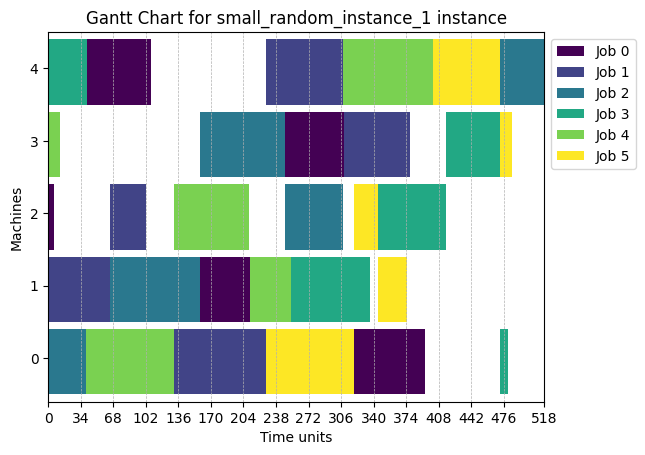

In [12]:
plot_gantt_chart(schedule)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Gantt Chart for small_random_instance_1 instance'}, xlabel='Time units', ylabel='Machines'>)

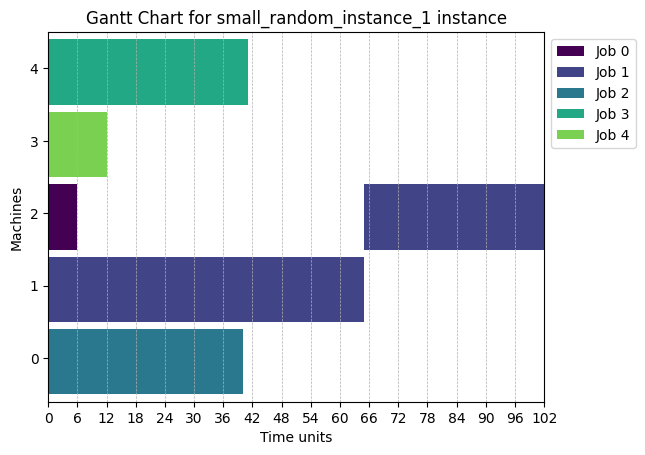

In [13]:
plot_gantt_chart(env.unwrapped.dispatcher.schedule)

In [14]:
action_probs

{(0, 4, 0): 0,
 (6, 0, 1): 0,
 (9, 1, 2): 0,
 (14, 1, 3): 0,
 (18, 0, 4): 0,
 (22, 0, 5): 0}

In [ ]:
env.unwrapped.dispatcher.ready_operations_filter

<function job_shop_lib.dispatching._ready_operation_filters.filter_dominated_operations(dispatcher: job_shop_lib.dispatching._dispatcher.Dispatcher, operations: List[job_shop_lib._operation.Operation]) -> List[job_shop_lib._operation.Operation]>

In [ ]:
print(env.unwrapped.dispatcher.subscribers[-6])

CompositeFeatureObserver:
------------------------
operations:
    Duration  EarliestStartTime  IsScheduled  PositionInJob
0        9.0              -10.0          1.0            0.0
1        3.0                0.0          1.0            0.0
2        2.0                6.0          0.0            0.0
3        6.0              -19.0          1.0            0.0
4       -2.0              -13.0          1.0            0.0
5        2.0                2.0          0.0            0.0
6       10.0              -13.0          1.0            0.0
7        0.0               -1.0          1.0            0.0
8        6.0                0.0          0.0            0.0
9        0.0              -19.0          1.0            0.0
10       3.0              -13.0          1.0            0.0
11      -2.0              -10.0          1.0            0.0
machines:
   Duration  EarliestStartTime  IsScheduled  RemainingOperations
0       8.0                0.0          0.0                 -1.0
1       2.0      

In [ ]:
env.unwrapped.job_shop_graph.instance.to_dict()

{'name': 'classic_generated_instance_498',
 'duration_matrix': [[9, 3, 2], [6, 1, 2], [10, 1, 6], [6, 3, 7]],
 'machines_matrix': [[2, 1, 0], [2, 0, 1], [1, 2, 0], [1, 2, 0]],
 'metadata': {}}

In [ ]:
print(env.unwrapped.dispatcher.current_time())

19


In [ ]:
action_probs

{(2, 0, 0): 0, (5, 1, 1): 1, (8, 0, 2): 1}

In [ ]:
observations, action_probabilities_sequence = dataset[schedule.instance.name]
assert len(observations) == len(action_probabilities_sequence)

In [ ]:
hetero_dataset = []
for obs, action_probs in zip(observations, action_probabilities_sequence):
    job_shop_data = JobShopData()
    for key, value in obs.items():
        for subkey, subvalue in value.items():
            if key == "node_features_dict":
                job_shop_data[subkey].x = torch.from_numpy(subvalue)
            elif key == "edge_index_dict":
                job_shop_data[subkey].edge_index = torch.from_numpy(subvalue)
    job_shop_data["y"] = torch.tensor(list(action_probs.values()))
    job_shop_data["valid_pairs"] = torch.tensor(list(action_probs.keys()))
    hetero_dataset.append(job_shop_data)

In [ ]:
hetero_dataset[0].edge_index_dict

{('operation',
  'to',
  'operation'): tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
           4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
           9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
          13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
          18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
          22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26,
          27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29],
         [ 1,  2,  3,  4,  0,  2,  3,  4,  0,  1,  3,  4,  0,  1,  2,  4,  0,  1,
           2,  3,  6,  7,  8,  9,  5,  7,  8,  9,  5,  6,  8,  9,  5,  6,  7,  9,
           5,  6,  7,  8, 11, 12, 13, 14, 10, 12, 13, 14, 10, 11, 13, 14, 10, 11,
          12, 14, 10, 11, 12, 13, 16, 17, 18, 19, 15, 17, 18, 19, 15, 16, 18, 19,
          15, 16, 17, 19, 15, 16, 17, 18, 21, 22, 23, 24, 20, 22, 23, 24, 20, 21,
 

In [ ]:
from gnn_scheduler.model import ResidualSchedulingGNN, HeteroMetadata

metadata = HeteroMetadata(node_types=["operation", "machine"])


model = ResidualSchedulingGNN(
    metadata=metadata, in_channels_dict={"operation": 8, "machine": 4}
)

a = model(
    hetero_dataset[0].x_dict,
    hetero_dataset[0].edge_index_dict,
    hetero_dataset[0].valid_pairs,
)

In [ ]:
hetero_dataset[0]

HeteroData(
  y=[6],
  valid_pairs=[6, 3],
  operation={ x=[30, 8] },
  machine={ x=[5, 4] },
  (operation, to, operation)={ edge_index=[2, 120] },
  (operation, to, machine)={ edge_index=[2, 30] },
  (machine, to, operation)={ edge_index=[2, 30] },
  (machine, to, machine)={ edge_index=[2, 20] }
)

In [ ]:
torch.cat([a, a], dim=0)

tensor([[ 0.0851],
        [-0.1582],
        [-0.0196],
        [-0.3940],
        [ 0.0272],
        [-0.2747],
        [ 0.0851],
        [-0.1582],
        [-0.0196],
        [-0.3940],
        [ 0.0272],
        [-0.2747]], grad_fn=<CatBackward0>)